In [62]:
from lifelines import KaplanMeierFitter,NelsonAalenFitter,WeibullFitter,CoxPHFitter, WeibullAFTFitter
import lifelines.datasets as dt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.statistics import logrank_test

## Select the dataset

Other sets can include:
* load_canadian_senators
* load_dd
* load_dfcv
* load_g3
* load_holly_molly_polly

In [63]:
#load in the data
df = dt.load_psychiatric_patients()

## Explore your set a bit

You can try out:
* histograms
* bar charts
* stacked bar charts
* scatter plots 
* colored scatterplots
* anything else you can think of

In [64]:
#get the head
df.head()

,Age,T,C,sex
0,51,1,1,2
1,58,1,1,2
2,55,2,1,2
3,28,22,1,2
4,21,30,0,1


Try out the encoder

In [65]:
#instantiate the encoder
le_s = LabelEncoder()
#transform
sex_lis = le_s.fit_transform(df['sex'])
#put in data
df['sex'] = sex_lis

<AxesSubplot:ylabel='Frequency'>

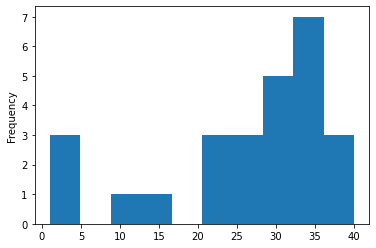

In [66]:
#plot the histogram
df['T'].plot(kind = 'hist')

<AxesSubplot:xlabel='C'>

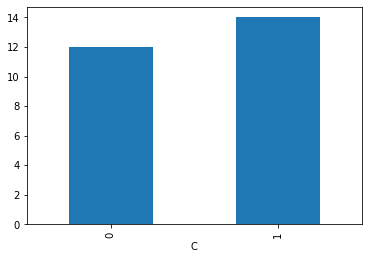

In [67]:
#event occurance 
df.groupby('C').count()['Age'].plot(kind = 'bar')

<AxesSubplot:xlabel='Age', ylabel='T'>

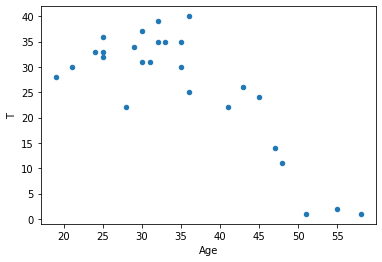

In [68]:
#plot scatter
df.plot(x = 'Age', y = 'T', kind = 'scatter')

<AxesSubplot:xlabel='sex'>

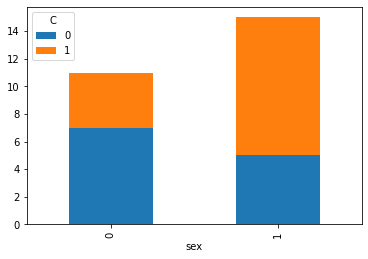

In [69]:
#plot stacked bar chart
df.groupby(['sex','C']).count()['Age'].unstack().plot(kind = 'bar', stacked = True)

<AxesSubplot:xlabel='Age', ylabel='T'>

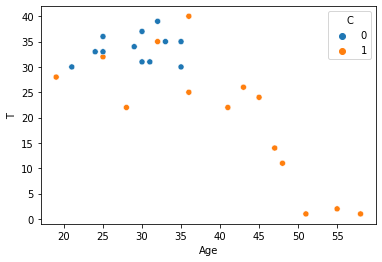

In [70]:
#plot colored scatterplot
sns.scatterplot(data = df, x = 'Age', y = 'T', hue = 'C')

## Survival Modeling

Now let's get into the survival modeling, we'll go over two techniques:
* Survival Curve
* Cumulative Hazard Curve

Start by isolating your time and event columns

In [71]:
#get the list of time
T = df['T']
#get the list of event occurances
E = df['C']

Now let's fit the Kaplan Meier curve

<AxesSubplot:xlabel='timeline'>

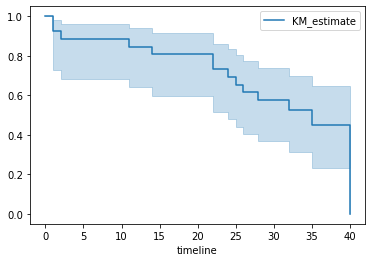

In [72]:
#instantiate kaplan meier curve
km = KaplanMeierFitter()
#fit the curve using the kaplan meier method
km.fit(T,event_observed = E)
#plot the kaplan meier curve
km.plot()

Now let's take a look at the hazard curve

<AxesSubplot:xlabel='timeline'>

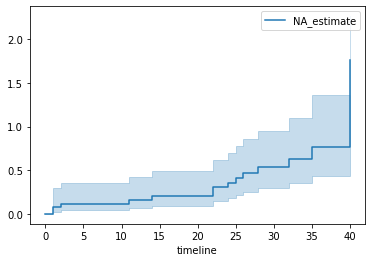

In [73]:
#instantiate nelson aalen fitter
na = NelsonAalenFitter(nelson_aalen_smoothing = False)
#fit the nelson aalen curve
na.fit(T, event_observed = E)
#plot the nelson aalen curve
na.plot()

Now try comparing some survival curves using the log rank test

In [74]:
male_group = df[df['sex'] == 1]
female_group = df[df['sex'] == 2]


results = logrank_test(male_group['T'], female_group['T'], event_observed_A=male_group['C'], event_observed_B=female_group['C'])
print(results)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 0
         test_name = logrank_test

---
 test_statistic   p  -log2(p)
           0.00 NaN       NaN


## Try a Parametric Curve

<AxesSubplot:>

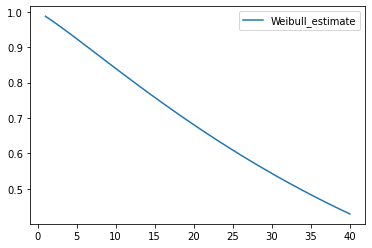

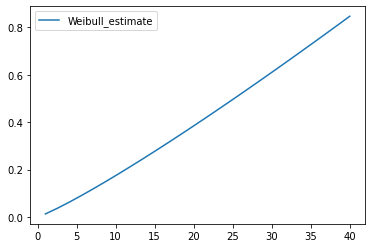

In [75]:
#instantiate the weibull fitter curve
wf = WeibullFitter()
#fit the weibull curve
wf.fit(T,event_observed = E)
#plot the survival function
wf.survival_function_.plot()
#plot the cumulative hazard curve
wf.cumulative_hazard_.plot()

Now make a prediction

In [76]:
#make a prediction using your parametric curve
wf.predict(41)

0.41837764383974685

## Now let's try some to create some survival curves affected by covariates

Let's make these multi-covariate models:
* CoxPH Model
* AFT fitter model

In [77]:
#instantiate the CoxPHFitter model
cph = CoxPHFitter()
#fit the coxph model on the data
cph.fit(df, duration_col = 'T', event_col = 'C')
#print the coxph summary
cph.print_summary()
#get hazard ratios
cph.hazard_ratios_

<lifelines.CoxPHFitter: fitted with 26 total observations, 12 right-censored observations>
             duration col = 'T'
                event col = 'C'
      baseline estimation = breslow
   number of observations = 26
number of events observed = 14
   partial log-likelihood = -27.25
         time fit was run = 2023-04-13 12:32:57 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Age         0.21       1.23       0.06             0.09             0.32                 1.10                 1.38
sex        -0.52       0.59       0.74            -1.97             0.92                 0.14                 2.51

            cmp to     z      p   -log2(p)
covariate                                 
Age           0.00  3.56 <0.005      11.40
sex           0.00 -0.71   0.48       1.07
---
Concordance = 0.82
Partial AIC = 58.50
log-likelihood ratio test = 20.91 on 2 df
-log2(p) of ll-ratio test = 15.08

covariate
Age    1.230629
sex    0.592300
Name: exp(coef), dtype: float64

Now let's make some unique survival curves

<AxesSubplot:>

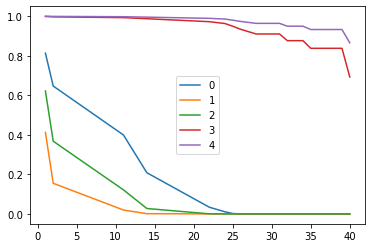

In [78]:
#create the inputs
X = df.drop(['T','C'],axis=1)
#create the survival functions using the coxph fitter for the first 5 entities
survival_cph = cph.predict_survival_function(X[0:5])
#plot the survival functions
survival_cph.plot()

Now let's make the cumulative hazard function

<AxesSubplot:>

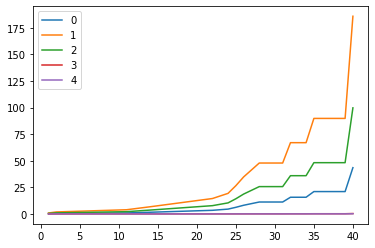

In [79]:
#get unique hazard curves
hazard_cph = cph.predict_cumulative_hazard(X[0:5])
#plot unique hazard curves
hazard_cph.plot()

## AFT Models

Fit the weibull aft model

In [80]:
#create the weibull aft fitter
waft = WeibullAFTFitter()
#fit the weibull aft fitter to the data
waft.fit(df, duration_col = 'T', event_col = 'C')
#get hazard ratios
waft.hazard_ratios_

param    covariate
lambda_  Age             0.891682
         sex             1.136322
         Intercept    2209.114575
rho_     Intercept       1.729417
Name: exp(coef), dtype: float64

Let's create these unique parametric curves

<AxesSubplot:>

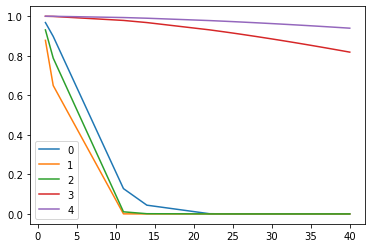

In [81]:
#create the survival function for the first 5 individuals
survival_waft = waft.predict_survival_function(X[0:5])
#plot the survival curves using the aft fitter
survival_waft.plot()

Let's create the cumulative hazard curves

<AxesSubplot:>

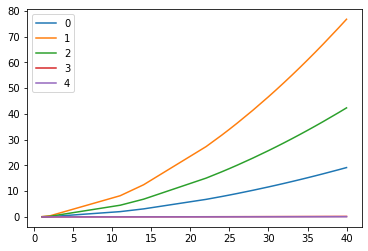

In [82]:
#get unique hazard curves
hazard_waft = waft.predict_cumulative_hazard(X[0:5])
#plot unique hazard curves
hazard_waft.plot()

Try some predictions:

In [83]:
#predict survival using the aft fitter
waft.predict_survival_function(X.loc[0,:], times = 50)

,0
50.0,5.680287e-13
